In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sys
sys.path.append("../libs/")
from utils import shift_join_data, mae,rmse,mape
from models import build_mlp

Using TensorFlow backend.


In [2]:
def split_df(a: pd.DataFrame, test_prop: float):
    iso = a.index.get_level_values('iso').unique().to_numpy()
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    for i in iso:
        df_temp = a.loc[i].copy()
        df_temp['iso'] = i
        years = df_temp.index.to_numpy()
        n = len(years)
        test_year = years[-1] - n * (test_prop)
        df_train = df_train.append(df_temp.loc[ : test_year].copy())
        df_test = df_test.append(df_temp.loc[test_year : ].copy())
    df_train = df_train.reset_index()
    df_test = df_test.reset_index()
    df_train = df_train.set_index(['iso','year'])
    df_test = df_test.set_index(['iso','year'])
    return df_train, df_test

# Carga de datos

In [3]:
df = pd.read_csv('../data/wb_dataset_prep.csv')
df = df.drop('country',axis=1)
iso = df['iso'].unique()    #Codigos de paises
df = df.set_index(['iso','year'])

In [4]:
#df_train, df_test = split_df(df, 0.3)
#df_val = df_test.copy()

In [5]:
print(iso)

['DEU' 'AUS' 'AUT' 'BGD' 'BEL' 'BOL' 'BRA' 'CAN' 'CHL' 'CHN' 'COL' 'CRI'
 'HRV' 'DNK' 'ECU' 'SLV' 'ESP' 'USA' 'EST' 'RUS' 'FIN' 'FRA' 'GRC' 'GTM'
 'HND' 'HUN' 'IND' 'IDN' 'IRL' 'ISL' 'ISR' 'ITA' 'JPN' 'JOR' 'KEN' 'LTU'
 'LUX' 'MYS' 'MLT' 'MAR' 'MEX' 'NGA' 'NOR' 'NLD' 'PAK' 'PAN' 'PRY' 'PER'
 'POL' 'PRT' 'GBR' 'EGY' 'KOR' 'ROU' 'SWE' 'CHE' 'TUR' 'URY' 'NZL']


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2145 entries, ('DEU', 1991) to ('NZL', 2021)
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   trade        2145 non-null   float64
 1   exports      2145 non-null   float64
 2   imports      2145 non-null   float64
 3   ggfce        2145 non-null   float64
 4   gfcf         2145 non-null   float64
 5   industry     2145 non-null   float64
 6   manufact     2145 non-null   float64
 7   unempl       2145 non-null   float64
 8   agriculture  2145 non-null   float64
 9   rgdp_growth  2145 non-null   float64
 10  infl_cpi     2145 non-null   float64
 11  oil          2145 non-null   float64
 12  gold         2145 non-null   float64
 13  copper       2145 non-null   float64
 14  sp500        2145 non-null   float64
dtypes: float64(15)
memory usage: 260.6+ KB


# Dividir Datos

In [7]:
iso_test = ['PER']
iso_train = iso[(iso != iso_test[0])]
target_col = ['rgdp_growth']
features = df.columns[(df.columns!=target_col[0])]

In [8]:
print(iso_train)

['DEU' 'AUS' 'AUT' 'BGD' 'BEL' 'BOL' 'BRA' 'CAN' 'CHL' 'CHN' 'COL' 'CRI'
 'HRV' 'DNK' 'ECU' 'SLV' 'ESP' 'USA' 'EST' 'RUS' 'FIN' 'FRA' 'GRC' 'GTM'
 'HND' 'HUN' 'IND' 'IDN' 'IRL' 'ISL' 'ISR' 'ITA' 'JPN' 'JOR' 'KEN' 'LTU'
 'LUX' 'MYS' 'MLT' 'MAR' 'MEX' 'NGA' 'NOR' 'NLD' 'PAK' 'PAN' 'PRY' 'POL'
 'PRT' 'GBR' 'EGY' 'KOR' 'ROU' 'SWE' 'CHE' 'TUR' 'URY' 'NZL']


In [9]:
print(features)

Index(['trade', 'exports', 'imports', 'ggfce', 'gfcf', 'industry', 'manufact',
       'unempl', 'agriculture', 'infl_cpi', 'oil', 'gold', 'copper', 'sp500'],
      dtype='object')


In [10]:
_, df_test = split_df(df,0.3)

# Normalizar

In [11]:
df_x_train = df.loc[iso_train][features].copy()
df_y_train = df.loc[iso_train][target_col].copy()
df_x_test = df_test.loc[iso_test][features].copy()
df_y_test = df_test.loc[iso_test][target_col].copy()

std_scaler_x_train = StandardScaler()
std_scaler_y_train = StandardScaler()
std_scaler_x_test = StandardScaler()
std_scaler_y_test = StandardScaler()

df_x_train.iloc[:,:] = std_scaler_x_train.fit_transform(df_x_train)
df_y_train.iloc[:,:] = std_scaler_y_train.fit_transform(df_y_train)
df_x_test.iloc[:,:] = std_scaler_x_test.fit_transform(df_x_test)
df_y_test.iloc[:,:] = std_scaler_y_test.fit_transform(df_y_test)

df_x_train.iloc[:,:] = np.clip(df_x_train,-5,5)
df_y_train.iloc[:,:] = np.clip(df_y_train,-5,5)
df_x_test.iloc[:,:] = np.clip(df_x_test,-5,5)
df_y_test.iloc[:,:] = np.clip(df_y_test,-5,5)

# Generar variables lag y horizonte

In [12]:
n_steps_in = 5
n_steps_out = 3
n_features = len(features)

x_train, y_train = shift_join_data(df_x_train,df_y_train,iso_train,n_steps_in,n_steps_out)
x_test, y_test = shift_join_data(df_x_test,df_y_test,iso_test,n_steps_in,n_steps_out)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=50,restore_best_weights=True)

In [30]:
n_batch = len(x_train)

In [31]:
n_batch

1686

In [32]:
mlp = build_mlp(n_steps_in,n_features,n_steps_out,250,2,1e-4,'relu')

In [33]:
history = mlp.fit(x_train,y_train,epochs=2000,batch_size=n_batch,validation_split=0.3,verbose=0,callbacks=[es],shuffle=False)

In [19]:
import matplotlib.pyplot as plt

In [20]:
def plot_loss(history,metric):
    fig, ax = plt.subplots(figsize = (8,5))
    ax.plot(history.history[metric],label='train '+metric)
    ax.plot(history.history['val_'+metric],label='validation '+metric)
    ax.legend()

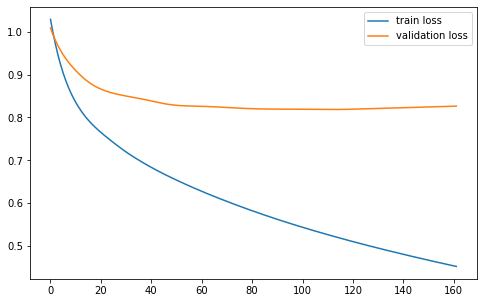

In [34]:
plot_loss(history,'loss')

In [35]:
y_pred = mlp.predict(x_test)

In [36]:
dn_y_test = std_scaler_y_test.inverse_transform(y_test)
dn_y_pred = std_scaler_y_test.inverse_transform(y_pred)

In [37]:
mae(dn_y_test, dn_y_pred)

array([0.91466153, 2.41488654, 3.88822527])

In [38]:
rmse(dn_y_test, dn_y_pred)


array([1.49154049, 4.14193559, 5.29632239])

In [39]:
mape(dn_y_test,dn_y_pred)

array([34.38948355, 46.65778755, 66.84655855])

In [40]:
def plot_pred(orig,pred):
    y_o, y_p = orig.T, pred.T
    n = len(y_o)
    fig, axes = plt.subplots(n,figsize=(5,12))
    for i in range(n):
        line_o, = axes[i].plot(y_o[i],label='orig')
        line_p, = axes[i].plot(y_p[i],label='pred')
        axes[i].legend(handles=[line_o,line_p])

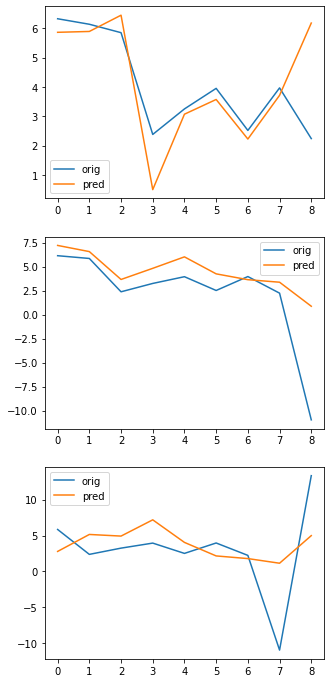

In [41]:
plot_pred(dn_y_test, dn_y_pred)